# DCN


# 1. Install & Import Packages

In [ ]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

     |████████████████████████████████| 51kB 5.7MB/s 
     |████████████████████████████████| 3.6MB 13.2MB/s 


In [ ]:

import os
import pandas as pd

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

import pprint

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import tensorflow as tf
import tensorflow_recommenders as tfrs

from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Lambda, Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LambdaCallback, EarlyStopping, Callback
from tensorflow.keras.utils import plot_model
import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def get_path(filename):
  return f'/content/drive/MyDrive/tobigs14_conference/data/v_2/wine_meta/{filename}'

# 많은 파일 불러올때
#glob.glob("/content/drive/MyDrive/tobigs14_conference/data/v_2/*")

In [ ]:
train = pd.read_json(get_path('train_all_meta_v2.json'))
test = pd.read_json(get_path('test_all_meta_v2.json'))

In [ ]:
train.head()

,index,user_note,rating_per_user,vintage_id,user_like_count,userID,wine_id,wine_name,url,like,name,rating_count,rating_average,rating_distribution,label_count,review_count,type_id,body,acidity,alcohol,food,grapes,grapes_id,grapes_count,grape_composition,rank,region_id,region_name,country_code,country_most_used_grapes_id,country_most_used_grapes_name,country_most_used_grapes_wines_count,winery_id,winery_name,winery_ratings_count,winery_ratings_average,winery_labels_count,winery_wines_count,user_follower_count,user_following_count,user_rating_count,user_rating_sum,reviews_count
0,0,Soooo good 💕,4.0,164942680,0,19484511,1141133,Prestige Rosé Brut ChampagnenN.V.,/taittinger-prestige-rose-brut-champagne/w/114...,1,Prestige Rosé Brut Champagne,5248.0,4.1,"{'1': 22, '2': 68, '3': 853, '4': 3447, '5': 858}",18046.0,1798.0,3.0,3.0,3.0,12.0,"[Pork, Rich fish (salmon, tuna etc), Shellfish...","[Chardonnay, Pinot Noir, Pinot Meunier]","[5, 14, 110]","[510440, 483935, 30275]","{'14': 70, '5': 30}",{'country': {'description': 'Rank within Franc...,409.0,Champagne,fr,"[14, 10, 5]","[Pinot Noir, Merlot, Chardonnay]","[483935, 482768, 510440]",1285.0,Taittinger,90187.0,4.2,454478.0,39.0,34,65,383,1453.0,323
1,1,"Belíssimo champanhe rose, bem seco mais com mu...",4.0,164942680,2,352674,1141133,Prestige Rosé Brut ChampagnenN.V.,/taittinger-prestige-rose-brut-champagne/w/114...,1,Prestige Rosé Brut Champagne,5248.0,4.1,"{'1': 22, '2': 68, '3': 853, '4': 3447, '5': 858}",18046.0,1798.0,3.0,3.0,3.0,12.0,"[Pork, Rich fish (salmon, tuna etc), Shellfish...","[Chardonnay, Pinot Noir, Pinot Meunier]","[5, 14, 110]","[510440, 483935, 30275]","{'14': 70, '5': 30}",{'country': {'description': 'Rank within Franc...,409.0,Champagne,fr,"[14, 10, 5]","[Pinot Noir, Merlot, Chardonnay]","[483935, 482768, 510440]",1285.0,Taittinger,90187.0,4.2,454478.0,39.0,425,915,382,1516.5,297
2,4,,4.0,164942680,0,17786617,1141133,Prestige Rosé Brut ChampagnenN.V.,/taittinger-prestige-rose-brut-champagne/w/114...,1,Prestige Rosé Brut Champagne,5248.0,4.1,"{'1': 22, '2': 68, '3': 853, '4': 3447, '5': 858}",18046.0,1798.0,3.0,3.0,3.0,12.0,"[Pork, Rich fish (salmon, tuna etc), Shellfish...","[Chardonnay, Pinot Noir, Pinot Meunier]","[5, 14, 110]","[510440, 483935, 30275]","{'14': 70, '5': 30}",{'country': {'description': 'Rank within Franc...,409.0,Champagne,fr,"[14, 10, 5]","[Pinot Noir, Merlot, Chardonnay]","[483935, 482768, 510440]",1285.0,Taittinger,90187.0,4.2,454478.0,39.0,46,75,412,1589.0,170
3,5,Perfekt med gratinerede østers.,4.5,164942680,0,8078038,1141133,Prestige Rosé Brut ChampagnenN.V.,/taittinger-prestige-rose-brut-champagne/w/114...,1,Prestige Rosé Brut Champagne,5248.0,4.1,"{'1': 22, '2': 68, '3': 853, '4': 3447, '5': 858}",18046.0,1798.0,3.0,3.0,3.0,12.0,"[Pork, Rich fish (salmon, tuna etc), Shellfish...","[Chardonnay, Pinot Noir, Pinot Meunier]","[5, 14, 110]","[510440, 483935, 30275]","{'14': 70, '5': 30}",{'country': {'description': 'Rank within Franc...,409.0,Champagne,fr,"[14, 10, 5]","[Pinot Noir, Merlot, Chardonnay]","[483935, 482768, 510440]",1285.0,Taittinger,90187.0,4.2,454478.0,39.0,13,10,412,1465.0,392
4,6,Delicious!,4.0,164942680,0,3014532,1141133,Prestige Rosé Brut ChampagnenN.V.,/taittinger-prestige-rose-brut-champagne/w/114...,0,Prestige Rosé Brut Champagne,5248.0,4.1,"{'1': 22, '2': 68, '3': 853, '4': 3447, '5': 858}",18046.0,1798.0,3.0,3.0,3.0,12.0,"[Pork, Rich fish (salmon, tuna etc), Shellfish...","[Chardonnay, Pinot Noir, Pinot Meunier]","[5, 14, 110]","[510440, 483935, 30275]","{'14': 70, '5': 30}",{'country': {'description': 'Rank within Franc...,409.0,Champagne,fr,"[14, 10, 5]","[Pinot Noir, Merlot, Chardonnay]","[483935, 482768, 510440]",1285.0,Taittinger,90187.0,4.2,454478.0,39.0,5,0,410,1639.5,394


In [ ]:
train.shape, test.shape

((763387, 43), (188718, 43))

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train, train_valid=train_test_split(train)

In [ ]:
len(train['userID'].unique())

6339

In [ ]:
len(test['userID'].unique())

6343

# 2. Preprocess

- train_data 생성

In [ ]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [ ]:
train.head()

,index,user_note,rating_per_user,vintage_id,user_like_count,userID,wine_id,wine_name,url,like,name,rating_count,rating_average,rating_distribution,label_count,review_count,type_id,body,acidity,alcohol,food,grapes,grapes_id,grapes_count,grape_composition,rank,region_id,region_name,country_code,country_most_used_grapes_id,country_most_used_grapes_name,country_most_used_grapes_wines_count,winery_id,winery_name,winery_ratings_count,winery_ratings_average,winery_labels_count,winery_wines_count,user_follower_count,user_following_count,user_rating_count,user_rating_sum,reviews_count
0,186311,"This is quite a special wine, all the hallmark...",4.5,158266699,6,45612185,1172337,Vouvrayn2018,/champalou-vouvray/w/1172337?year=2018,1,Vouvray,3816.0,4.0,"{'1': 17, '2': 69, '3': 866, '4': 2346, '5': 518}",13633.0,193.0,2.0,3.0,3.0,12.5,"[Rich fish (salmon, tuna etc), Vegetarian, Pou...",[Chenin Blanc],[6],[49431],{'6': 100},{'country': {'description': 'Rank within Franc...,731.0,Vouvray,fr,"[14, 10, 5]","[Pinot Noir, Merlot, Chardonnay]","[483935, 482768, 510440]",3368.0,Champalou,5838.0,4.0,21198.0,12.0,52,223,351,1429.0,351
1,57121,"A bit nasty to be honest, fairly acidic, not a...",1.5,4180965,0,2173627,1164231,Rioja Jovenn2014,/federico-paternina-rioja-joven/w/1164231?year...,0,Rioja Joven,11131.0,3.2,"{'1': 531, '2': 1677, '3': 5611, '4': 2715, '5...",149100.0,36.0,1.0,4.0,3.0,0.0,"[Beef, Lamb, Veal, Poultry]",[Tempranillo],[19],[148562],{},{'country': {'description': 'Rank within Spain...,492.0,Rioja,es,"[19, 142, 2]","[Tempranillo, Garnacha, Cabernet Sauvignon]","[148562, 49674, 687800]",17889.0,Cepa Lebrel,30472.0,3.3,373658.0,9.0,50,72,372,1325.0,278
2,664484,"Frutas vermelhas, amora, framboesa, morangos, ...",5.0,1705502,21,286103,43944,Bramare Marchiori Vineyard Malbecn2010,/vina-cobos-bramare-marchiori-vineyard-malbec/...,1,Bramare Marchiori Vineyard Malbec,7999.0,4.5,"{'1': 26, '2': 36, '3': 327, '4': 4554, '5': 3...",29552.0,43.0,1.0,5.0,3.0,14.0,"[Beef, Lamb, Poultry]",[Malbec],[9],[187465],{'9': 100},{'country': {'description': 'Rank within Argen...,454.0,Mendoza,ar,"[9, 2, 5]","[Malbec, Cabernet Sauvignon, Chardonnay]","[187465, 687800, 510440]",8824.0,Viña Cobos,165252.0,4.2,668623.0,32.0,361,295,310,1270.5,261
3,584748,2019 Samule Smith&Son new release tastingn6/10...,3.0,14152059,3,31700371,7773,Côtes-du-Rhône Rougen2015,/e-guigal-cotes-du-rhone-rouge/w/7773?year=2015,0,Côtes-du-Rhône Rouge,51355.0,3.6,"{'1': 583, '2': 2446, '3': 24176, '4': 21155, ...",377780.0,836.0,1.0,4.0,3.0,13.0,"[Beef, Lamb, Game (deer, venison)]","[Shiraz/Syrah, Grenache, Mourvedre]","[1, 8, 22]","[467266, 198748, 84850]","{'1': 100, '22': 100}",{'country': {'description': 'Rank within Franc...,429.0,Côtes-du-Rhône,fr,"[14, 10, 5]","[Pinot Noir, Merlot, Chardonnay]","[483935, 482768, 510440]",1314.0,E. Guigal,187678.0,3.9,1494310.0,34.0,64,12,323,1106.0,319
4,201614,Medium plus alcohol. Rudy red color. Medium mi...,4.5,4348598,2,22202106,6569,Cabernet Sauvignonn2014,/honig-vineyard-and-winery-cabernet-sauvignon/...,1,Cabernet Sauvignon,13541.0,4.2,"{'1': 70, '2': 147, '3': 1698, '4': 8528, '5':...",89726.0,282.0,1.0,5.0,2.0,14.5,"[Beef, Lamb, Game (deer, venison), Mature and ...",[Cabernet Sauvignon],[2],[687800],{'2': 100},{'country': {'description': 'Rank within Unite...,25.0,Napa Valley,us,"[2, 14, 5]","[Cabernet Sauvignon, Pinot Noir, Chardonnay]","[687800, 483935, 510440]",841.0,Honig,27612.0,4.1,179268.0,17.0,4,1,410,1542.5,185


In [ ]:
train.isna().sum()

index                                       0
user_note                                   0
rating_per_user                             0
vintage_id                                  0
user_like_count                             0
userID                                      0
wine_id                                     0
wine_name                                   0
url                                         0
like                                        0
name                                       22
rating_count                               22
rating_average                             22
rating_distribution                        22
label_count                                22
review_count                               22
type_id                                    22
body                                    43268
acidity                                 43268
alcohol                                    22
food                                     8100
grapes                            

In [ ]:
train.dtypes

index                                     int64
user_note                                object
rating_per_user                         float64
vintage_id                                int64
user_like_count                           int64
userID                                    int64
wine_id                                   int64
wine_name                                object
url                                      object
like                                      int64
name                                     object
rating_count                            float64
rating_average                          float64
rating_distribution                      object
label_count                             float64
review_count                            float64
type_id                                 float64
body                                    float64
acidity                                 float64
alcohol                                 float64
food                                    

- int: type_id, body, acidity, like, user_like_count, alchol, rank, grapes_id, winery_id
- str: UserID, wine_id, country_code, 

In [ ]:
train = train[~train.body.isna()].reset_index(drop=True)
train = train[~train.winery_id.isna()].reset_index(drop=True)
train = train[~train.region_id.isna()].reset_index(drop=True)

In [ ]:
train.isna().sum()

index                                      0
user_note                                  0
rating_per_user                            0
vintage_id                                 0
user_like_count                            0
userID                                     0
wine_id                                    0
wine_name                                  0
url                                        0
like                                       0
name                                       0
rating_count                               0
rating_average                             0
rating_distribution                        0
label_count                                0
review_count                               0
type_id                                    0
body                                       0
acidity                                    0
alcohol                                    0
food                                     100
grapes                                  1363
grapes_id 

float 형태 데이터: rating_per_user, rating_average, winery_ratings_average, <br>
grapes_id랑 같은 형태: country_most_used_grapes_wine_count, 

In [ ]:
INT_FEATURES = ["type_id", "body", "acidity", "like", 'user_like_count', 'rating_count', 'alcohol', 'winery_id', 'region_id', 'user_rating_count']

for int_feature in INT_FEATURES:
  train[int_feature] = train[int_feature].astype(int)

train.country_code= train.country_code.fillna('un')

In [ ]:
train['grapes_id_unique'] = train.grapes_id.map(lambda x: x[0] if x else 0)

In [ ]:
train.dtypes

index                                     int64
user_note                                object
rating_per_user                         float64
vintage_id                                int64
user_like_count                           int64
userID                                    int64
wine_id                                   int64
wine_name                                object
url                                      object
like                                      int64
name                                     object
rating_count                              int64
rating_average                          float64
rating_distribution                      object
label_count                             float64
review_count                            float64
type_id                                   int64
body                                      int64
acidity                                   int64
alcohol                                   int64
food                                    

In [ ]:
train.head()

,index,user_note,rating_per_user,vintage_id,user_like_count,userID,wine_id,wine_name,url,like,name,rating_count,rating_average,rating_distribution,label_count,review_count,type_id,body,acidity,alcohol,food,grapes,grapes_id,grapes_count,grape_composition,rank,region_id,region_name,country_code,country_most_used_grapes_id,country_most_used_grapes_name,country_most_used_grapes_wines_count,winery_id,winery_name,winery_ratings_count,winery_ratings_average,winery_labels_count,winery_wines_count,user_follower_count,user_following_count,user_rating_count,user_rating_sum,reviews_count,grapes_id_unique
0,186311,"This is quite a special wine, all the hallmark...",4.5,158266699,6,45612185,1172337,Vouvrayn2018,/champalou-vouvray/w/1172337?year=2018,1,Vouvray,3816,4.0,"{'1': 17, '2': 69, '3': 866, '4': 2346, '5': 518}",13633.0,193.0,2,3,3,12,"[Rich fish (salmon, tuna etc), Vegetarian, Pou...",[Chenin Blanc],[6],[49431],{'6': 100},{'country': {'description': 'Rank within Franc...,731,Vouvray,fr,"[14, 10, 5]","[Pinot Noir, Merlot, Chardonnay]","[483935, 482768, 510440]",3368,Champalou,5838.0,4.0,21198.0,12.0,52,223,351,1429.0,351,6
1,57121,"A bit nasty to be honest, fairly acidic, not a...",1.5,4180965,0,2173627,1164231,Rioja Jovenn2014,/federico-paternina-rioja-joven/w/1164231?year...,0,Rioja Joven,11131,3.2,"{'1': 531, '2': 1677, '3': 5611, '4': 2715, '5...",149100.0,36.0,1,4,3,0,"[Beef, Lamb, Veal, Poultry]",[Tempranillo],[19],[148562],{},{'country': {'description': 'Rank within Spain...,492,Rioja,es,"[19, 142, 2]","[Tempranillo, Garnacha, Cabernet Sauvignon]","[148562, 49674, 687800]",17889,Cepa Lebrel,30472.0,3.3,373658.0,9.0,50,72,372,1325.0,278,19
2,664484,"Frutas vermelhas, amora, framboesa, morangos, ...",5.0,1705502,21,286103,43944,Bramare Marchiori Vineyard Malbecn2010,/vina-cobos-bramare-marchiori-vineyard-malbec/...,1,Bramare Marchiori Vineyard Malbec,7999,4.5,"{'1': 26, '2': 36, '3': 327, '4': 4554, '5': 3...",29552.0,43.0,1,5,3,14,"[Beef, Lamb, Poultry]",[Malbec],[9],[187465],{'9': 100},{'country': {'description': 'Rank within Argen...,454,Mendoza,ar,"[9, 2, 5]","[Malbec, Cabernet Sauvignon, Chardonnay]","[187465, 687800, 510440]",8824,Viña Cobos,165252.0,4.2,668623.0,32.0,361,295,310,1270.5,261,9
3,584748,2019 Samule Smith&Son new release tastingn6/10...,3.0,14152059,3,31700371,7773,Côtes-du-Rhône Rougen2015,/e-guigal-cotes-du-rhone-rouge/w/7773?year=2015,0,Côtes-du-Rhône Rouge,51355,3.6,"{'1': 583, '2': 2446, '3': 24176, '4': 21155, ...",377780.0,836.0,1,4,3,13,"[Beef, Lamb, Game (deer, venison)]","[Shiraz/Syrah, Grenache, Mourvedre]","[1, 8, 22]","[467266, 198748, 84850]","{'1': 100, '22': 100}",{'country': {'description': 'Rank within Franc...,429,Côtes-du-Rhône,fr,"[14, 10, 5]","[Pinot Noir, Merlot, Chardonnay]","[483935, 482768, 510440]",1314,E. Guigal,187678.0,3.9,1494310.0,34.0,64,12,323,1106.0,319,1
4,201614,Medium plus alcohol. Rudy red color. Medium mi...,4.5,4348598,2,22202106,6569,Cabernet Sauvignonn2014,/honig-vineyard-and-winery-cabernet-sauvignon/...,1,Cabernet Sauvignon,13541,4.2,"{'1': 70, '2': 147, '3': 1698, '4': 8528, '5':...",89726.0,282.0,1,5,2,14,"[Beef, Lamb, Game (deer, venison), Mature and ...",[Cabernet Sauvignon],[2],[687800],{'2': 100},{'country': {'description': 'Rank within Unite...,25,Napa Valley,us,"[2, 14, 5]","[Cabernet Sauvignon, Pinot Noir, Chardonnay]","[687800, 483935, 510440]",841,Honig,27612.0,4.1,179268.0,17.0,4,1,410,1542.5,185,2


# test data 생성

In [ ]:
test

,index,user_note,rating_per_user,vintage_id,user_like_count,userID,wine_id,wine_name,url,like,name,rating_count,rating_average,rating_distribution,label_count,review_count,type_id,body,acidity,alcohol,food,grapes,grapes_id,grapes_count,grape_composition,rank,region_id,region_name,country_code,country_most_used_grapes_id,country_most_used_grapes_name,country_most_used_grapes_wines_count,winery_id,winery_name,winery_ratings_count,winery_ratings_average,winery_labels_count,winery_wines_count,user_follower_count,user_following_count,user_rating_count,user_rating_sum,reviews_count
0,932958,90p,4.0,2999861,3,1201,1214547,Chablis Premier Cru 'Montée de Tonnerre'n2011,/raveneau-chablis-premier-cru-montee-de-tonner...,0,Chablis Premier Cru 'Montée de Tonnerre',2381.0,4.4,"{'1': 9, '2': 14, '3': 147, '4': 1364, '5': 847}",7926.0,10.0,2.0,4.0,3.0,0.0,"[Pork, Rich fish (salmon, tuna etc), Shellfish...",[Chardonnay],[5],[510440],{},{'country': {'description': 'Rank within Franc...,3657.0,Chablis 1er Cru 'Montee de Tonnerre',fr,"[14, 10, 5]","[Pinot Noir, Merlot, Chardonnay]","[483935, 482768, 510440]",30580.0,Raveneau,8831.0,4.4,27233.0,11.0,128,90,267,1185.5,212
1,932927,93-94p,4.0,2434772,4,1201,1099253,Vosne-Romanée 1er Cru Cros Parantouxn2008,/rouget-emmanuel-vosne-romanee-1er-cru-cros-pa...,0,Vosne-Romanée 1er Cru Cros Parantoux,640.0,4.5,"{'1': 7, '2': 4, '3': 33, '4': 298, '5': 298}",3194.0,2.0,1.0,3.0,3.0,0.0,"[Beef, Veal, Game (deer, venison), Poultry]",[Pinot Noir],[14],[483935],{},{'country': {'description': 'Rank within Franc...,3015.0,Vosne-Romanée Premier Cru,fr,"[14, 10, 5]","[Pinot Noir, Merlot, Chardonnay]","[483935, 482768, 510440]",1672.0,Emmanuel Rouget,4675.0,4.1,22843.0,19.0,128,90,267,1185.5,212
2,932983,92p,4.0,3083114,1,1201,1684223,Pauillac (Premier Grand Cru Classé)n1998,/chateau-mouton-rothschild-pauillac-premier-gr...,0,Pauillac (Premier Grand Cru Classé),55718.0,4.6,"{'1': 704, '2': 566, '3': 2970, '4': 20709, '5...",460494.0,177.0,1.0,4.0,3.0,0.0,"[Beef, Lamb, Game (deer, venison), Poultry]","[Cabernet Sauvignon, Cabernet Franc, Merlot]","[2, 3, 10]","[687800, 229829, 482768]","{'10': 100, '2': 100}",{'country': {'description': 'Rank within Franc...,393.0,Pauillac,fr,"[14, 10, 5]","[Pinot Noir, Merlot, Chardonnay]","[483935, 482768, 510440]",64252.0,Château Mouton Rothschild,65932.0,4.5,546010.0,7.0,128,90,267,1185.5,212
3,932929,95p :-),5.0,2221950,4,1201,100044,Chambolle-Musigny 1er Cru 'Amoureuses'n2007,/domaine-g-roumier-chambolle-musigny-1er-cru-a...,1,Chambolle-Musigny 1er Cru 'Amoureuses',296.0,4.6,"{'1': 1, '2': 0, '3': 17, '4': 120, '5': 158}",953.0,0.0,1.0,3.0,3.0,0.0,"[Beef, Veal, Game (deer, venison), Poultry]",[Pinot Noir],[14],[483935],{},{'country': {'description': 'Rank within Franc...,3678.0,Chambolle-Musigny 1er Cru 'Les Amoureuses',fr,"[14, 10, 5]","[Pinot Noir, Merlot, Chardonnay]","[483935, 482768, 510440]",1444.0,Domaine G. Roumier,7748.0,4.4,32387.0,15.0,128,90,267,1185.5,212
4,932907,96p,5.0,2309050,6,1201,1107909,La Sereine Noire Côte-Rôtien1999,/domaine-gangloff-la-sereine-noire-cote-rotie/...,1,La Sereine Noire Côte-Rôtie,817.0,4.4,"{'1': 5, '2': 9, '3': 66, '4': 440, '5': 297}",3061.0,9.0,1.0,5.0,3.0,0.0,"[Beef, Lamb, Game (deer, venison), Poultry]",[Shiraz/Syrah],[1],[467266],{},{'country': {'description': 'Rank within Franc...,693.0,Côte-Rôtie,fr,"[14, 10, 5]","[Pinot Noir, Merlot, Chardonnay]","[483935, 482768, 510440]",3406.0,Domaine Yves Gangloff,4163.0,4.4,15116.0,8.0,128,90,267,1185.5,212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188713,931874,Muy elegante presentación y mejor sabor. Muy b...,4.0,6580165,0,46404017,1155203,Gên2013,/emiliana-ge/w/1155203?year=2013,1,Gê,3592.0,4.4,"{'1': 12, '2': 37, '3': 266, '4': 2132, '5': 1...",17501.0,36.0,1.0,NaN,NaN,14.6,"[Beef, Lamb, Spicy food, Mature and hard chees...","[Shiraz/Syrah, Cabernet Sauvigno

In [ ]:
# 결측치 다 날린다? 
test.isna().sum()

index                                       0
user_note                                   0
rating_per_user                             0
vintage_id                                  0
user_like_count                             0
userID                                      0
wine_id                                     0
wine_name                                   0
url                                         0
like                                        0
name                                        7
rating_count                                7
rating_average                              7
rating_distribution                         7
label_count                                 7
review_count                                7
type_id                                     7
body                                    14271
acidity                                 14271
alcohol                                     7
food                                     2648
grapes                            

In [ ]:
test = test[~test.body.isna()].reset_index(drop=True)
test = test[~test.winery_id.isna()].reset_index(drop=True)
test = test[~test.region_id.isna()].reset_index(drop=True)

In [ ]:
test.isna().sum()

index                                     0
user_note                                 0
rating_per_user                           0
vintage_id                                0
user_like_count                           0
userID                                    0
wine_id                                   0
wine_name                                 0
url                                       0
like                                      0
name                                      0
rating_count                              0
rating_average                            0
rating_distribution                       0
label_count                               0
review_count                              0
type_id                                   0
body                                      0
acidity                                   0
alcohol                                   0
food                                     30
grapes                                  422
grapes_id                       

In [ ]:
INT_FEATURES = ["type_id", "body", "acidity", "like", 'user_like_count', 'rating_count', 'alcohol', 'winery_id', 'region_id', 'user_rating_count']


for int_feature in INT_FEATURES:
  test[int_feature] = test[int_feature].astype(int)

test.country_code= test.country_code.fillna('un')
test['grapes_id_unique'] = test.grapes_id.map(lambda x: x[0] if x else 0)

In [ ]:
test.dtypes

index                                     int64
user_note                                object
rating_per_user                         float64
vintage_id                                int64
user_like_count                           int64
userID                                    int64
wine_id                                   int64
wine_name                                object
url                                      object
like                                      int64
name                                     object
rating_count                              int64
rating_average                          float64
rating_distribution                      object
label_count                             float64
review_count                            float64
type_id                                   int64
body                                      int64
acidity                                   int64
alcohol                                   int64
food                                    

- int: type_id, body, acidity, like, user_like_count, alcohol, grapes_id, winery_id
- str: UserID, wine_id, country_code, 

In [ ]:
train.head()

,index,user_note,rating_per_user,vintage_id,user_like_count,userID,wine_id,wine_name,url,like,name,rating_count,rating_average,rating_distribution,label_count,review_count,type_id,body,acidity,alcohol,food,grapes,grapes_id,grapes_count,grape_composition,rank,region_id,region_name,country_code,country_most_used_grapes_id,country_most_used_grapes_name,country_most_used_grapes_wines_count,winery_id,winery_name,winery_ratings_count,winery_ratings_average,winery_labels_count,winery_wines_count,user_follower_count,user_following_count,user_rating_count,user_rating_sum,reviews_count,grapes_id_unique
0,186311,"This is quite a special wine, all the hallmark...",4.5,158266699,6,45612185,1172337,Vouvrayn2018,/champalou-vouvray/w/1172337?year=2018,1,Vouvray,3816,4.0,"{'1': 17, '2': 69, '3': 866, '4': 2346, '5': 518}",13633.0,193.0,2,3,3,12,"[Rich fish (salmon, tuna etc), Vegetarian, Pou...",[Chenin Blanc],[6],[49431],{'6': 100},{'country': {'description': 'Rank within Franc...,731,Vouvray,fr,"[14, 10, 5]","[Pinot Noir, Merlot, Chardonnay]","[483935, 482768, 510440]",3368,Champalou,5838.0,4.0,21198.0,12.0,52,223,351,1429.0,351,6
1,57121,"A bit nasty to be honest, fairly acidic, not a...",1.5,4180965,0,2173627,1164231,Rioja Jovenn2014,/federico-paternina-rioja-joven/w/1164231?year...,0,Rioja Joven,11131,3.2,"{'1': 531, '2': 1677, '3': 5611, '4': 2715, '5...",149100.0,36.0,1,4,3,0,"[Beef, Lamb, Veal, Poultry]",[Tempranillo],[19],[148562],{},{'country': {'description': 'Rank within Spain...,492,Rioja,es,"[19, 142, 2]","[Tempranillo, Garnacha, Cabernet Sauvignon]","[148562, 49674, 687800]",17889,Cepa Lebrel,30472.0,3.3,373658.0,9.0,50,72,372,1325.0,278,19
2,664484,"Frutas vermelhas, amora, framboesa, morangos, ...",5.0,1705502,21,286103,43944,Bramare Marchiori Vineyard Malbecn2010,/vina-cobos-bramare-marchiori-vineyard-malbec/...,1,Bramare Marchiori Vineyard Malbec,7999,4.5,"{'1': 26, '2': 36, '3': 327, '4': 4554, '5': 3...",29552.0,43.0,1,5,3,14,"[Beef, Lamb, Poultry]",[Malbec],[9],[187465],{'9': 100},{'country': {'description': 'Rank within Argen...,454,Mendoza,ar,"[9, 2, 5]","[Malbec, Cabernet Sauvignon, Chardonnay]","[187465, 687800, 510440]",8824,Viña Cobos,165252.0,4.2,668623.0,32.0,361,295,310,1270.5,261,9
3,584748,2019 Samule Smith&Son new release tastingn6/10...,3.0,14152059,3,31700371,7773,Côtes-du-Rhône Rougen2015,/e-guigal-cotes-du-rhone-rouge/w/7773?year=2015,0,Côtes-du-Rhône Rouge,51355,3.6,"{'1': 583, '2': 2446, '3': 24176, '4': 21155, ...",377780.0,836.0,1,4,3,13,"[Beef, Lamb, Game (deer, venison)]","[Shiraz/Syrah, Grenache, Mourvedre]","[1, 8, 22]","[467266, 198748, 84850]","{'1': 100, '22': 100}",{'country': {'description': 'Rank within Franc...,429,Côtes-du-Rhône,fr,"[14, 10, 5]","[Pinot Noir, Merlot, Chardonnay]","[483935, 482768, 510440]",1314,E. Guigal,187678.0,3.9,1494310.0,34.0,64,12,323,1106.0,319,1
4,201614,Medium plus alcohol. Rudy red color. Medium mi...,4.5,4348598,2,22202106,6569,Cabernet Sauvignonn2014,/honig-vineyard-and-winery-cabernet-sauvignon/...,1,Cabernet Sauvignon,13541,4.2,"{'1': 70, '2': 147, '3': 1698, '4': 8528, '5':...",89726.0,282.0,1,5,2,14,"[Beef, Lamb, Game (deer, venison), Mature and ...",[Cabernet Sauvignon],[2],[687800],{'2': 100},{'country': {'description': 'Rank within Unite...,25,Napa Valley,us,"[2, 14, 5]","[Cabernet Sauvignon, Pinot Noir, Chardonnay]","[687800, 483935, 510440]",841,Honig,27612.0,4.1,179268.0,17.0,4,1,410,1542.5,185,2


# validation

In [ ]:
train_valid.isna().sum()

index                                       0
user_note                                   0
rating_per_user                             0
vintage_id                                  0
user_like_count                             0
userID                                      0
wine_id                                     0
wine_name                                   0
url                                         0
like                                        0
name                                        4
rating_count                                4
rating_average                              4
rating_distribution                         4
label_count                                 4
review_count                                4
type_id                                     4
body                                    14426
acidity                                 14426
alcohol                                     4
food                                     2694
grapes                            

In [ ]:
train_valid = train_valid[~train_valid.body.isna()].reset_index(drop=True)
train_valid = train_valid[~train_valid.winery_id.isna()].reset_index(drop=True)
train_valid = train_valid[~train_valid.region_id.isna()].reset_index(drop=True)

In [ ]:
train_valid.shape

(176342, 43)

In [ ]:
INT_FEATURES = ["type_id", "body", "acidity", "like", 'user_like_count', 'rating_count', 'alcohol', 'winery_id', 'region_id', 'user_rating_count']


for int_feature in INT_FEATURES:
  train_valid[int_feature] = train_valid[int_feature].astype(int)

train_valid.country_code= train_valid.country_code.fillna('un')
train_valid['grapes_id_unique'] = train_valid.grapes_id.map(lambda x: x[0] if x else 0)

## dic type변경

In [ ]:
INT_FEATURES = ["type_id", "body", "acidity", "like", 'user_like_count', 'rating_count', 'alcohol', 'winery_id', 'region_id', 'user_rating_count']

In [ ]:
str_features = ["userID", "country_code", 'grapes_id_unique']
int_features = ["type_id", "body", "acidity", "like", 'user_like_count', 'rating_count', 'alcohol', 'winery_id', 'region_id', 'user_rating_count']

In [ ]:
train_str_dict = {
    str_feature: [str(val).encode() for val in train[str_feature].values]
    for str_feature in str_features
}

train_int_dict = {
    int_feature: train[int_feature].values
    for int_feature in int_features
}

In [ ]:
train_str_dict.update(train_int_dict)
train_str_dict.keys()

dict_keys(['userID', 'country_code', 'grapes_id_unique', 'type_id', 'body', 'acidity', 'like', 'user_like_count', 'rating_count', 'alcohol', 'winery_id', 'region_id', 'user_rating_count'])

In [ ]:
test_str_dict = {
    str_feature: [str(val).encode() for val in test[str_feature].values]
    for str_feature in str_features
}

test_int_dict = {
    int_feature: test[int_feature].values
    for int_feature in int_features
}

test_str_dict.update(test_int_dict)
test_str_dict.keys()

dict_keys(['userID', 'country_code', 'grapes_id_unique', 'type_id', 'body', 'acidity', 'like', 'user_like_count', 'rating_count', 'alcohol', 'winery_id', 'region_id', 'user_rating_count'])

In [ ]:
train = tf.data.Dataset.from_tensor_slices(train_str_dict)
test = tf.data.Dataset.from_tensor_slices(test_str_dict)

In [ ]:
train_val_str_dict = {
    str_feature: [str(val).encode() for val in train_valid[str_feature].values]
    for str_feature in str_features
}

train_val_int_dict = {
    int_feature: train_valid[int_feature].values
    for int_feature in int_features
}
train_val_str_dict.update(train_val_int_dict)
train_val_str_dict.keys()

dict_keys(['userID', 'country_code', 'grapes_id_unique', 'type_id', 'body', 'acidity', 'like', 'user_like_count', 'rating_count', 'alcohol', 'winery_id', 'region_id', 'user_rating_count'])

In [ ]:
train_val_str_dict.keys()

dict_keys(['userID', 'country_code', 'grapes_id_unique', 'type_id', 'body', 'acidity', 'like', 'user_like_count', 'rating_count', 'alcohol', 'winery_id', 'region_id', 'user_rating_count'])

In [ ]:
train_valid = tf.data.Dataset.from_tensor_slices(train_val_str_dict)

In [ ]:
train_valid

<TensorSliceDataset shapes: {userID: (), country_code: (), grapes_id_unique: (), type_id: (), body: (), acidity: (), like: (), user_like_count: (), rating_count: (), alcohol: (), winery_id: (), region_id: (), user_rating_count: ()}, types: {userID: tf.string, country_code: tf.string, grapes_id_unique: tf.string, type_id: tf.int64, body: tf.int64, acidity: tf.int64, like: tf.int64, user_like_count: tf.int64, rating_count: tf.int64, alcohol: tf.int64, winery_id: tf.int64, region_id: tf.int64, user_rating_count: tf.int64}>

In [ ]:
# tf.keras.layers.experimental.preprocessing.
feature_names = ["userID", "country_code", 'grapes_id_unique', "type_id", "body", "acidity", "like", 'user_like_count', 'rating_count', 'alcohol', 'winery_id', 'region_id', 'user_rating_count']

In [ ]:
vocabularies = {}

for feature_name in feature_names:
  vocab = train.batch(1_000_000).map(lambda x: x[feature_name])
  vocabularies[feature_name] = np.unique(np.concatenate(list(vocab)))

In [ ]:
vocabularies

{'acidity': array([1, 2, 3]),
 'alcohol': array([  0,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  80, 112, 114, 135]),
 'body': array([1, 2, 3, 4, 5]),
 'country_code': array([b'ar', b'at', b'au', b'br', b'ca', b'ch', b'cl', b'de', b'es',
        b'fr', b'gb', b'gr', b'hu', b'il', b'it', b'jp', b'lu', b'mx',
        b'nz', b'pt', b'ru', b'us', b'uy', b'za'], dtype=object),
 'grapes_id_unique': array([b'0', b'1', b'10', b'100', b'1005', b'1006', b'101', b'1011',
        b'1019', b'102', b'103', b'1030', b'1032', b'1033', b'1034',
        b'104', b'1044', b'105', b'106', b'1072', b'1074', b'108', b'109',
        b'1098', b'11', b'110', b'111', b'1116', b'112', b'1121', b'114',
        b'115', b'1156', b'116', b'1175', b'1176', b'1178', b'118',
        b'1185', b'119', b'12', b'120', b'122', b'1222', b'123', b'1232',
        b'124', b'1262', b'1265', b'1266', b'127', b'128', b'1281',
        b'1282', b'1285', b'129', b'1291', b'1

# Model

In [ ]:
class DCN(tfrs.Model):

  def __init__(self, use_cross_layer, deep_layer_sizes, projection_dim=None):
    super().__init__()

    self.embedding_dimension = 32

    str_features = ["userID", "country_code", 'grapes_id_unique']
    int_features = ["type_id", "body", "acidity", 'user_like_count', 'rating_count', 'alcohol', 'winery_id', 'region_id', 'user_rating_count']

    self._all_features = str_features + int_features
    self._embeddings = {}

    # Compute embeddings for string features.
    for feature_name in str_features:
      vocabulary = vocabularies[feature_name]
      self._embeddings[feature_name] = tf.keras.Sequential(
          [tf.keras.layers.experimental.preprocessing.StringLookup(
              vocabulary=vocabulary, mask_token=None),
           tf.keras.layers.Embedding(len(vocabulary) + 1,
                                     self.embedding_dimension)
    ])
      
    # Compute embeddings for int features.
    for feature_name in int_features:
      vocabulary = vocabularies[feature_name]
      self._embeddings[feature_name] = tf.keras.Sequential(
          [tf.keras.layers.experimental.preprocessing.IntegerLookup(
              vocabulary=vocabulary, mask_value=None),
           tf.keras.layers.Embedding(len(vocabulary) + 1,
                                     self.embedding_dimension)
    ])

    if use_cross_layer:
      self._cross_layer = tfrs.layers.dcn.Cross(
          projection_dim=projection_dim,
          kernel_initializer="glorot_uniform")
    else:
      self._cross_layer = None

    self._deep_layers = [tf.keras.layers.Dense(layer_size, activation="softmax")
      for layer_size in deep_layer_sizes]

    self._logit_layer = tf.keras.layers.Dense(1)

    self.task = tfrs.tasks.Ranking(
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=[tf.keras.metrics.BinaryCrossentropy("binary_crossentropy")]
    )

  def call(self, features):
    # Concatenate embeddings
    embeddings = []
    for feature_name in self._all_features:
      embedding_fn = self._embeddings[feature_name]
      embeddings.append(embedding_fn(features[feature_name]))

    x = tf.concat(embeddings, axis=1)

    # Build Cross Network
    if self._cross_layer is not None:
      x = self._cross_layer(x)
    
    # Build Deep Network
    for deep_layer in self._deep_layers:
      x = deep_layer(x)

    return self._logit_layer(x)

  def compute_loss(self, features, training=False):
    labels = features.pop("like")
    scores = self(features)
    return self.task(
        labels=labels,
        predictions=scores,
    )

In [ ]:
learning_rate = 0.001

In [ ]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_val_train = train_valid.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(5989).cache()

In [ ]:
model = DCN(use_cross_layer=True, deep_layer_sizes=[192, 192], projection_dim=None)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))

# Train & Result

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
import tensorflow_datasets as tfds

cached_test_numpy = tfds.as_numpy(cached_test)
y_true = [item['like'] for item in cached_test_numpy]
y_true = np.concatenate(y_true)

In [ ]:
def get_result(model):
  y_pred = model.predict(cached_test).flatten()
  y_pred_class = [1 if pred > 0.5 else 0 for pred in y_pred]

  print(f"ROC: {roc_auc_score(y_true, y_pred)}")
  print(classification_report(y_true, y_pred_class))

In [ ]:
from keras.callbacks import EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
history= model.fit(cached_train,  epochs=100, verbose=True, callbacks=[callback], validation_data=cached_val_train)

Epoch 1/100
65/65 [==============================] - 13s 155ms/step - binary_crossentropy: 2.3657 - loss: 2.3624 - regularization_loss: 0.0000e+00 - total_loss: 2.3624 - val_binary_crossentropy: 2.1510 - val_loss: 2.1530 - val_regularization_loss: 0.0000e+00 - val_total_loss: 2.1530
Epoch 2/100
65/65 [==============================] - 1s 21ms/step - binary_crossentropy: 2.0734 - loss: 2.0721 - regularization_loss: 0.0000e+00 - total_loss: 2.0721 - val_binary_crossentropy: 1.9995 - val_loss: 2.0014 - val_regularization_loss: 0.0000e+00 - val_total_loss: 2.0014
Epoch 3/100
65/65 [==============================] - 1s 21ms/step - binary_crossentropy: 1.9122 - loss: 1.9103 - regularization_loss: 0.0000e+00 - total_loss: 1.9103 - val_binary_crossentropy: 1.7894 - val_loss: 1.7911 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.7911
Epoch 4/100
65/65 [==============================] - 1s 21ms/step - binary_crossentropy: 1.6968 - loss: 1.6956 - regularization_loss: 0.0000e+00 - total

In [ ]:
get_result(model)

ROC: 0.7810712170155855
              precision    recall  f1-score   support

           0       0.79      0.62      0.70     80975
           1       0.73      0.86      0.79     93390

    accuracy                           0.75    174365
   macro avg       0.76      0.74      0.74    174365
weighted avg       0.76      0.75      0.75    174365



In [ ]:
model.summary()

Model: "dcn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 32)                128       
_________________________________________________________________
sequential_8 (Sequential)    (None, 32)                800       
_________________________________________________________________
sequential_4 (Sequential)    (None, 32)                192       
_________________________________________________________________
sequential_1 (Sequential)    (None, 32)                800       
_________________________________________________________________
sequential_2 (Sequential)    (None, 32)                12768     
_________________________________________________________________
sequential_7 (Sequential)    (None, 32)                247552    
_________________________________________________________________
sequential_10 (Sequential)   (None, 32)                51232   

<Figure size 648x648 with 0 Axes>

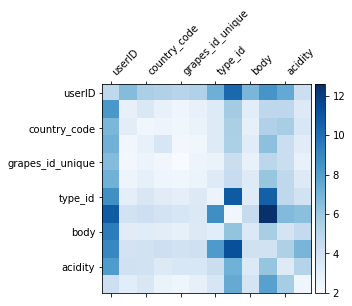

In [ ]:
mat = model._cross_layer._dense.kernel
features = model._all_features

block_norm = np.ones([len(features), len(features)])

dim = model.embedding_dimension

# Compute the norms of the blocks.
for i in range(len(features)):
  for j in range(len(features)):
    block = mat[i * dim:(i + 1) * dim,
                j * dim:(j + 1) * dim]
    block_norm[i,j] = np.linalg.norm(block, ord="fro")

plt.figure(figsize=(9,9))
im = plt.matshow(block_norm, cmap=plt.cm.Blues)
ax = plt.gca()
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
cax.tick_params(labelsize=10) 
_ = ax.set_xticklabels([""] + features, rotation=45, ha="left", fontsize=10)
_ = ax.set_yticklabels([""] + features, fontsize=10)

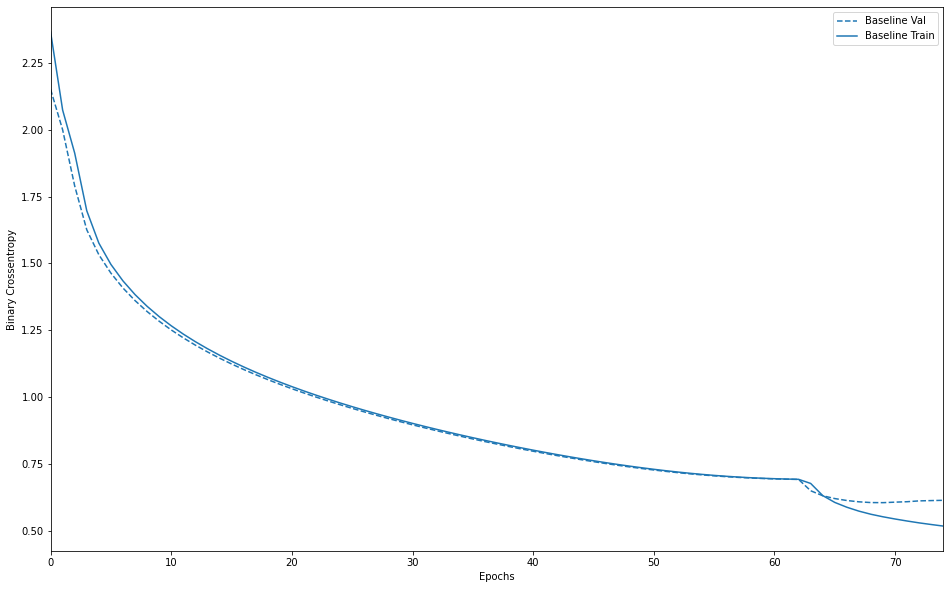

In [ ]:
def plot_history(histories, key='binary_crossentropy'):
  plt.figure(figsize=(16,10))

  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])


plot_history([('baseline', history)])